In [1]:
!pip install ftfy

     |████████████████████████████████| 53 kB 1.4 MB/s 


In [2]:
!pip install faiss-cpu

     |████████████████████████████████| 8.6 MB 3.8 MB/s 


In [3]:

import sys
from google.colab import drive
drive.mount('/content/drive') # 授权 Google Drive
sys.path.append('/content/drive/MyDrive/Colab Notebooks/utils/clip') # 此为你的自定义模块的存储路径
sys.path.append('/content/drive/MyDrive/Colab Notebooks/utils/triplet_loss')

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import Sampler
import clip
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
import re
from simple_tokenizer import SimpleTokenizer
import faiss
import matplotlib.pyplot as plt
import albumentations
from triplet_loss import TripletLoss

%matplotlib inline

device = torch.device('cuda')
image_size = 512

Mounted at /content/drive


In [4]:
transforms_train = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.RandomBrightnessContrast(p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2)),
    albumentations.HueSaturationValue(p=0.5, hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2),
    albumentations.ShiftScaleRotate(p=0.5, shift_limit=0.0625, scale_limit=0.2, rotate_limit=20),
    albumentations.Normalize()
])

transforms_valid = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
    albumentations.Normalize()
])

In [5]:
class RollingMean():
    def __init__(self):
        self.n = 0
        self.mean = 0
        
    def update(self, value):
        self.mean = (self.mean * self.n + value) / (self.n+1)
        self.n += 1
        
    def result(self):
        return self.mean

In [6]:
_tokenizer = SimpleTokenizer()

# Copied from https://github.com/openai/CLIP/blob/beba48f35392a73c6c47ae67ddffced81ad1916d/clip/clip.py#L164
# but with relaxed exception
def tokenize(texts, context_length: int = 77) -> torch.LongTensor:
    if isinstance(texts, str):
        texts = [texts]

    sot_token = _tokenizer.encoder["<|startoftext|>"]
    eot_token = _tokenizer.encoder["<|endoftext|>"]
    all_tokens = [[sot_token] + _tokenizer.encode(text) + [eot_token] for text in texts]
    result = torch.zeros(len(all_tokens), context_length, dtype=torch.long)

    for i, tokens in enumerate(all_tokens):
        n = min(len(tokens), context_length)
        result[i, :n] = torch.tensor(tokens)[:n]
        if len(tokens) > context_length:
            result[i, -1] = tokens[-1]

    return result
# Remove EMOJI
RE_EMOJI = re.compile(r"\\x[A-Za-z0-9./]+", flags=re.UNICODE)

def strip_emoji(text):
    return RE_EMOJI.sub(r'', text)

In [7]:
class SameGroupSampler(Sampler):
    def __init__(self, df ,ds):
        super().__init__(ds)
        
        # Create a dictionary of posting_id -> index in dataset
        self.index_to_position = dict(zip(df.index, range(len(df))))
        
        # Create a Series of label_group -> set(posting_id)
        self.label_group = df.reset_index().groupby('label_group')['posting_id'].apply(set).map(sorted).map(np.array)

    def __len__(self):
        return len(self.label_group)
        
    def __iter__(self):
        for _ in range(len(self)):
            # Sample one label_group
            label_group_sample = self.label_group.sample(1).iloc[0]
            
            # Sample two posting_id's
            # sample1, sample2 = np.random.choice(label_group_sample, 2, replace=False)
            sample1, sample2 = np.random.choice(label_group_sample, 2, replace=True)
            
            yield self.index_to_position[sample1]
            yield self.index_to_position[sample2]      

In [8]:
class MyDataset(Dataset):
    def __init__(self, df, images_path):
        super().__init__()
        self.df = df
        self.images_path = images_path
        self.has_target = ('label_group' in df)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        image = preprocess(Image.open(self.images_path / row['image']))
        text = tokenize([strip_emoji(row['title'])])[0]
        
        if self.has_target:
            return image, text, row['label_group'] #row['label_group']就是后面的target
        else:
            return image, text, 0

In [9]:
# Load train data
train_images_path = Path('/content/drive/MyDrive/shopee-product-matching/train_images')

df_train = pd.read_csv('/content/drive/MyDrive/shopee-product-matching/train1.csv', index_col='posting_id')

dstrain = MyDataset(df_train, train_images_path)
dltrain = DataLoader(dstrain, batch_size=4, num_workers=2, sampler=SameGroupSampler(df_train, dstrain))

In [14]:
BATCH_SIZE = 4
# train_dataloader = DataLoader(dstrain, batch_size = BATCH_SIZE) #Define your own dataloader


#https://github.com/openai/CLIP/issues/57
def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float() 

device = "cuda:0" if torch.cuda.is_available() else "cpu" # If using GPU then use mixed precision training.
model, preprocess = clip.load("/content/drive/MyDrive/Colab Notebooks/utils/clip/ViT-B-32.pt", device=device, jit=False)

# Get embedding size
embed_dim = model.text_projection.shape[1]
embed_dim

512

In [44]:
def matrix_add(matrix1,matrix2):
    total_element = [matrix1[i][j] + matrix2[i][j] for i in range(len(matrix1)) for j in range(len(matrix1))]
    new_matrix = [total_element[x:x+len(matrix1)] for x in range(0,len(total_element),len(matrix1))]
    return new_matrix

In [52]:
EPOCH = 1
# model, preprocess = clip.load("ViT-B/32",device=device,jit=False) #Must set jit=False for training
# if device == "cpu":
#   model.float()
# else :
#   clip.model.convert_weights(model) # Actually this line is unnecessary since clip by default already on float16

loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.2)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, 1e-2, total_steps=EPOCH * (2*len(dltrain)-1),base_momentum=0.0, max_momentum=0.5, pct_start=0.1, div_factor=1e2, final_div_factor=1e4)
# optimizer = torch.optim.Adam(model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2) #Params used from paper, the lr is smaller, more safe for fine tuning to new dataset
criterion = TripletLoss(device)

for epoch in range(EPOCH):
    with tqdm(total=2*len(dltrain)-1) as bar:
        loss_mean = RollingMean()
        for images, texts, targets in dltrain :
        # for images, texts in dltrain :
            optim.zero_grad()
    
            # logits_per_image, logits_per_text = model(images.to(device), texts.to(device))

            # ground_truth = torch.arange(BATCH_SIZE,dtype=torch.long,device=device)  #对比训练的ground_truth，貌似是那条对角线？  
            #                                       #这里能不能把ground_truth直接改成label_group？

            # total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2
            images_features = model.encode_image(images.to(device))
            texts_features = model.encode_text(texts.to(device))

            # L2-normalize features
            images_features = images_features / images_features.norm(2, dim=1, keepdim=True)
            texts_features = texts_features / texts_features.norm(2, dim=1, keepdim=True)
            # features = (images_features + texts_features) / 2

            features = (0.4 * images_features + 0.6 * texts_features)

            # images_features = images_features * 0.4
            # texts_features = texts_features * 0.6
            # features = matrix_add(images_features.cpu().detach(), texts_features.cpu().detach())
            # features = np.array(features)


            targets = targets.to(device)
            # total_loss = torch.cosine_similarity(texts_features, images_features, dim=1)
            # total_loss = (criterion(images_features, targets) + criterion(texts_features, targets))/2
            total_loss = criterion(features, targets)

            total_loss.backward()
            optim.step()
            scheduler.step()
            
            loss_mean.update(total_loss.item())
            bar.update()
            bar.set_description('{:.4f}'.format(loss_mean.result()))
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optim.state_dict(),
        'loss': total_loss,
        }, f"/content/drive/MyDrive/shopee-product-matching/model_1.pt") #just change to your preferred folder/filename

  0%|          | 0/45 [00:00<?, ?it/s]

In [67]:
model, preprocess = clip.load("ViT-B/32",device=device,jit=False) #Must set jit=False for training
checkpoint = torch.load("/content/drive/MyDrive/shopee-product-matching/model_1.pt")

# # Use these 3 lines if you use default model setting(not training setting) of the clip. For example, if you set context_length to 100 since your string is very long during training, then assign 100 to checkpoint['model_state_dict']["context_length"] 
# checkpoint['model_state_dict']["input_resolution"] = model.input_resolution #default is 224
# checkpoint['model_state_dict']["context_length"] = model.context_length # default is 77
# checkpoint['model_state_dict']["vocab_size"] = model.vocab_size 

model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [68]:
# 这段是用前面finetune的权重生成image和text的feature，之后拼接，2*512，然后保存，等待和test集中的对比
def find_similarities_and_indexes(df, images_path, top_n=4, features_file=None):
    # Create pytorch Dataset/DataLoader
    ds = MyDataset(df, images_path)
    dl = DataLoader(ds, batch_size=32, shuffle=False, num_workers=2)

    # Allocate memory for features
    features = np.empty((len(df), embed_dim), dtype=np.float32)

    # Begin predict
    i = 0
    for images, texts, _ in tqdm(dl):
        n = len(images)
        with torch.no_grad():
            # Generate image and text features
            images_features = model.encode_image(images.to(device))
            texts_features = model.encode_text(texts.to(device))


            total_features = (0.4 * images_features + 0.6 * texts_features)

        # Concat features (first images then texts)
        features[i:i+n, :embed_dim] = total_features.cpu()
      
        i += n

        
    # features = features.cpu().numpy()
    # Option to save these features (may be usefull to tune cut value)
    if features_file is not None:
        # features = features.cpu().numpy()
        np.save(features_file, features)

    # l2-normalize
    features /= np.linalg.norm(features, 2, axis=1, keepdims=True)

# faiss是为稠密向量提供高效相似度搜索和聚类的框架: https://blog.csdn.net/kanbuqinghuanyizhang/article/details/80774609
    # Create index
    index = faiss.IndexFlatIP(embed_dim)     # d=2*emb 
    
    features = features.astype('float32')

    index.add(features)

    # Search index
    return index.search(features, top_n)

    # index.search返回两个参数，1.similarity,表示与相似向量的距离(distance)，2.indexes表示相似用户的ID。



    # TODO: try range_search
    # lims, similarities, indexes = index_test.range_search(test_features, GROUP_CUT)

  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


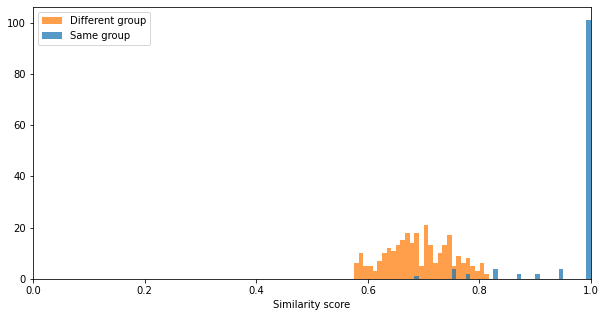

In [66]:
# 未finetune版
RUN_ON_TRAIN = 1
if RUN_ON_TRAIN:
    # Perform search of similiar items
    similarities, indexes = find_similarities_and_indexes(df_train, train_images_path, features_file='features-no-norm.npy')
    
    # `similarities` will have shape (n, top_n) and will have the similarites scores for closest matches
    # `indexes` will have shape (n, top_n) and have the index closest matches.
    # Both arrays are aligned

    # Convert index to groups, will have shape (n, top_n)
    found_groups = df_train['label_group'].values[indexes]

    # Check if matches are from same group. Will create a boolean vector of (n, top_n)
    is_same_group = (found_groups == df_train['label_group'].values[:, np.newaxis])

    # Plot similarities score from same group and different groups
    plt.figure(figsize=(10, 5))
    plt.hist([similarities[is_same_group], similarities[~is_same_group]], density=False, bins=51,
         label=['Same group', 'Different group'], histtype='stepfilled', alpha=0.75)
    plt.xlim(0, 1)
    plt.xlabel('Similarity score')
    plt.legend();

  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


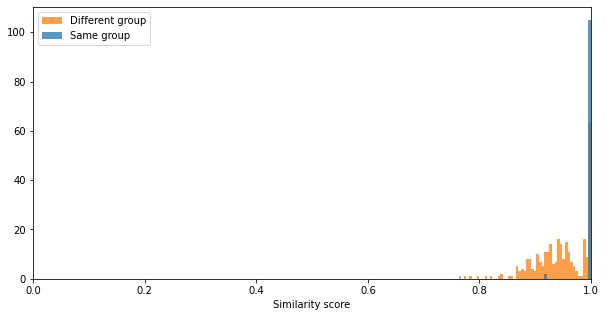

In [69]:
# 图文结合
RUN_ON_TRAIN = 1
if RUN_ON_TRAIN:
    # Perform search of similiar items
    similarities, indexes = find_similarities_and_indexes(df_train, train_images_path, features_file='features-no-norm.npy')
    
    # `similarities` will have shape (n, top_n) and will have the similarites scores for closest matches
    # `indexes` will have shape (n, top_n) and have the index closest matches.
    # Both arrays are aligned

    # Convert index to groups, will have shape (n, top_n)
    found_groups = df_train['label_group'].values[indexes]

    # Check if matches are from same group. Will create a boolean vector of (n, top_n)
    is_same_group = (found_groups == df_train['label_group'].values[:, np.newaxis])

    # Plot similarities score from same group and different groups
    plt.figure(figsize=(10, 5))
    plt.hist([similarities[is_same_group], similarities[~is_same_group]], density=False, bins=51,
         label=['Same group', 'Different group'], histtype='stepfilled', alpha=0.75)
    plt.xlim(0, 1)
    plt.xlabel('Similarity score')
    plt.legend();

  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


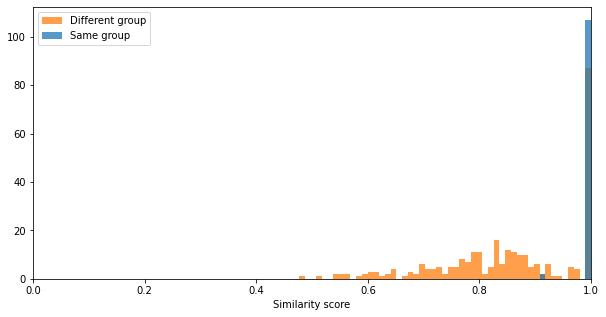

In [55]:
# 只使用图片
RUN_ON_TRAIN = 1
if RUN_ON_TRAIN:
    # Perform search of similiar items
    similarities, indexes = find_similarities_and_indexes(df_train, train_images_path, features_file='features-no-norm.npy')
    
    # `similarities` will have shape (n, top_n) and will have the similarites scores for closest matches
    # `indexes` will have shape (n, top_n) and have the index closest matches.
    # Both arrays are aligned

    # Convert index to groups, will have shape (n, top_n)
    found_groups = df_train['label_group'].values[indexes]

    # Check if matches are from same group. Will create a boolean vector of (n, top_n)
    is_same_group = (found_groups == df_train['label_group'].values[:, np.newaxis])

    # Plot similarities score from same group and different groups
    plt.figure(figsize=(10, 5))
    plt.hist([similarities[is_same_group], similarities[~is_same_group]], density=False, bins=51,
         label=['Same group', 'Different group'], histtype='stepfilled', alpha=0.75)
    plt.xlim(0, 1)
    plt.xlabel('Similarity score')
    plt.legend();

In [70]:
# SRC: https://www.kaggle.com/c/shopee-product-matching/discussion/224782#1233338
# With some adaptation
def row_wise_f1_score(y_true, y_pred):
    tp = np.array([len(x[0] & x[1]) for x in zip(y_true, y_pred)])
    fp = y_pred.apply(lambda x: len(x)).values - tp
    fn = y_true.apply(lambda x: len(x)).values - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * ((precision * recall) / (precision + recall))
    return f1


def calc_score(cut_value):
    # Apply cutoff of similarities
    groups_are_same = (similarities > cut_value)

    # Build results
    results = []
    for i, (group_is_same, index_result) in enumerate(zip(groups_are_same, indexes)):
        row_results = df_train.index[index_result[group_is_same]]

        # Keep found matches as a `set`
        results.append(set(row_results))

    df_results = pd.Series(results, index=df_answer.index)
    
    # Evaluate results
    return row_wise_f1_score(df_answer, df_results).mean()

  0%|          | 0/51 [00:10<?, ?it/s]

Best cutoff is 0.95 with expected F1 score of 0.6712


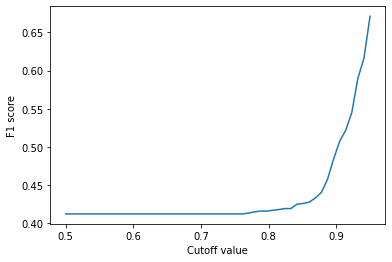

In [71]:
if RUN_ON_TRAIN:
    # Create answer dataframe. This will have posting_id on index and a set of label_group as values 
    groups = df_train.reset_index().groupby('label_group')['posting_id'].apply(set)
    df_answer = df_train['label_group'].map(groups)

    # Cut values to evaluate
    cuts = np.linspace(0.5, 0.95, 51)
    scores = [calc_score(c) for c in tqdm(cuts)]

    # Plot curve
    plt.plot(cuts, scores)
    plt.xlabel('Cutoff value')
    plt.ylabel('F1 score')

    print('Best cutoff is {:.2f} with expected F1 score of {:.4f}'.format(cuts[np.argmax(scores)], max(scores)))

In [ ]:
GROUP_CUT = 0.71  # Use option `RUN_ON_TRAIN` to find this number
test_images_path = Path('../input/shopee-product-matching/test_images')
# Find similar matches
similarities, indexes = find_similarities_and_indexes(df_test, test_images_path)

In [ ]:
# Apply cutoff of similiarites
test_are_same_groups = (similarities > GROUP_CUT)
# Build submission
results = []

for i, (test_is_same_group, index_result) in enumerate(zip(test_are_same_groups, indexes)):
    row_results = set(df_test.index[index_result[test_is_same_group]])
    
    results.append({
        'posting_id': df_test.index[i],
        'matches': ' '.join(row_results)
    })
    
df_sub = pd.DataFrame(results)
df_sub.to_csv('submission.csv', index=False)